In [ ]:
# The overall experiments will finish about 30 minutes using 20 CPUs
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=20'

import jax
jax.devices()

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple


class RCMDP(NamedTuple):
    S_set: jnp.array  # state space
    A_set: jnp.array  # action space
    discount: float  # discount
    costs: jnp.array  # cost functions
    threshes: jnp.array  # constraint thresholds
    U: jnp.array  # uncertainty set
    init_dist: jnp.array  # initial distribution

    @property
    def S(self) -> int:  # state space size
        return len(self.S_set)

    @property
    def A(self) -> int:  # action space size
        return len(self.A_set)


S, A = 15, 5  # state and action space sizes
N = 1  # number of constraints
USIZE = 5  # size of uncertainty set
DISCOUNT = 0.99 
ITER_LENGTH = 1000  # iteration length for experiment
NUM_SEEDS = 20  # number of evaluation seeds

In [3]:
import chex
from functools import partial


@partial(jax.vmap, in_axes=(None, None, 0, None), out_axes=0)
@partial(jax.vmap, in_axes=(None, None, None, 0), out_axes=0)
def compute_greedy_Q(discount: float, iter: int, cost: jnp.ndarray, P: jnp.ndarray):
    """Compute a greedy Q function with respect to the constraint cost function in P
    Args:
        discount (float)
        cost (jnp.ndarray)
        P (jnp.ndarray)

    Returns:
        optimal_Q (jnp.ndarray): (SxA)の行列
    """

    def backup(optimal_Q):
        next_v = P @ optimal_Q.min(axis=1)
        assert next_v.shape == (S, A)
        return cost + discount * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, iter, body_fn, optimal_Q)


@jax.jit
def projection_to_simplex(y):
    """project y to a probability simplex
    see：https://arxiv.org/pdf/1309.1541
    Args:
        y (jnp.ndarray): (A)-vector

    Returns:
        x (jnp.ndarray): (A)-vector
    """
    D = len(y)
    u = jnp.sort(y)[::-1]
    u_sum = jnp.cumsum(u)
    rho_pos_flag = (u + (1 - u_sum) / (jnp.arange(D) + 1)) > 0
    rho = jnp.argmax(jnp.cumsum(rho_pos_flag))
    lam = (1 - u_sum[rho]) / (rho + 1)
    x = jnp.maximum(y + lam, 0)
    return x


proj_to_Pi = jax.vmap(projection_to_simplex)

In [4]:
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
import chex


@jax.jit
def compute_policy_matrix(policy: jnp.ndarray):
    """
    Args:
        policy (jnp.ndarray): (SxA) array

    Returns:
        policy_matrix (jnp.ndarray): (SxSA) array
    """
    S, A = policy.shape
    PI = policy.reshape(1, S, A)
    PI = jnp.tile(PI, (S, 1, 1))
    eyes = jnp.eye(S).reshape(S, S, 1)
    PI = (eyes * PI).reshape(S, S*A)
    return PI


@partial(jax.vmap, in_axes=(None, None, 0, None), out_axes=0)
@partial(jax.vmap, in_axes=(None, None, None, 0), out_axes=0)
def compute_policy_Q(discount: float, policy: jnp.ndarray, cost: jnp.ndarray, P: jnp.ndarray):
    """ Do policy evaluation with cost and transition kernel
    Args:
        discount (float): discount factor
        policy (jnp.ndarray): (SxA) array
        cost (jnp.ndarray): cost function. (SxA) array
        P (jnp.ndarray): transition kernel. (SxAxS) array

    Returns:
        Q (jnp.ndarray): (SxA) array
    """
    S, A = policy.shape

    Pi = compute_policy_matrix(policy)
    PPi = P.reshape(S*A, S) @ Pi
    Q = jnp.linalg.inv(jnp.eye(S*A) - discount * PPi) @ cost.reshape(S*A)
    return Q.reshape(S, A)


@partial(jax.vmap, in_axes=(None, None, None, 0), out_axes=0)
def compute_policy_visit_s(discount: float, policy: jnp.ndarray, init_dist: jnp.ndarray, P: jnp.ndarray):
    """ Compute (unnormalized) occupancy measure of a policy
    Args:
        discount (float): discount factor
        policy (jnp.ndarray): (SxA) array
        init_dist: initial distribution
        P (jnp.ndarray): (SxAxS) array

    Returns:
        d_pi (jnp.ndarray): (S) array
    """
    Pi = compute_policy_matrix(policy)
    PiP = Pi @ P.reshape(S*A, S) 
    d_pi = init_dist @ jnp.linalg.inv(jnp.eye(S) - discount * PiP)
    return d_pi


In [5]:
from typing import NamedTuple, Optional
from jax.random import PRNGKey


def create_rcmdp(seed: int):
    key = PRNGKey(seed)

    S_set = jnp.arange(S)
    A_set = jnp.arange(A)
    const = jnp.zeros(N)  # dummy

    # randomly create cost function
    costs = jnp.ones((N+1, S, A))
    key, _key = jax.random.split(key)
    zero_mask = jax.random.bernoulli(_key, p=0.5, shape=costs.shape)
    costs = costs * zero_mask
    costs = costs.at[1].set(1 - costs[0])

    # create initial distribution
    key, _key = jax.random.split(key)
    init_dist = jax.random.dirichlet(key=_key, alpha=jnp.array([0.1] * S))
    # np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)

    # create uncertainty set
    U = jnp.zeros((USIZE, S, A, S))
    for u in range(USIZE):
        key, _key = jax.random.split(key)
        P = jax.random.dirichlet(key=_key, alpha=jnp.array([0.05] * S), shape=((S*A,)))
        P = P.reshape(S, A, S)
        # np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)
        U = U.at[u].set(P)

    rcmdp = RCMDP(S_set, A_set, DISCOUNT, costs, const, U, init_dist)


    # set the constraint threshold based on the possible constraint satisfaction
    const = 0
    greedy_Qs = compute_greedy_Q(rcmdp.discount, int(1 / (1-rcmdp.discount)) + 100, rcmdp.costs, rcmdp.U)
    greedy_idxes = greedy_Qs.argmin(axis=-1).reshape(-1, S)
    greedy_policy = jnp.zeros((S, A))
    for i in range((N+1) * USIZE):
        greedy_policy = greedy_policy.at[jnp.arange(S), greedy_idxes[i]].add(1)
    greedy_policy = greedy_policy / ((N+1) * USIZE)
    # np.testing.assert_allclose(greedy_policy.sum(axis=-1), 1, atol=1e-6)

    threshes = []
    Qs = compute_policy_Q(rcmdp.discount, greedy_policy, costs, rcmdp.U)
    Vs = (greedy_policy.reshape(1, 1, S, A) * Qs).sum(axis=-1)
    Js = (Vs * rcmdp.init_dist.reshape(1, 1, S)).sum(axis=-1)
    # assert Js.shape == (N + 1, USIZE)
    threshes = Js.max(axis=1)[1:]

    rcmdp = rcmdp._replace(threshes=jnp.array(threshes))
    return rcmdp

In [6]:
from functools import partial
from tqdm import tqdm
import chex


policy = jnp.ones((NUM_SEEDS, S, A)) / A
sum_policy = jnp.zeros((NUM_SEEDS, S, A))
lam = jnp.zeros((NUM_SEEDS, N))
res_J0U_list = jnp.zeros((NUM_SEEDS, ITER_LENGTH))
vios_list = jnp.zeros((NUM_SEEDS, ITER_LENGTH))
res_J0U_list = jnp.zeros((NUM_SEEDS, ITER_LENGTH))
vios_list = jnp.zeros((NUM_SEEDS, ITER_LENGTH))
res_J0U_avg_list = jnp.zeros((NUM_SEEDS, ITER_LENGTH))
vios_avg_list = jnp.zeros((NUM_SEEDS, ITER_LENGTH))

InitLagArgs = res_J0U_list, vios_list, res_J0U_avg_list, vios_avg_list, policy, sum_policy, lam 

@jax.jit
def solve_inner_Lagrange(lam: float, rcmdp: RCMDP, init_policy: jnp.ndarray, num_iter: int, lr: float):
    """Apply policy gradients to the inner minimization problem of the Lagrangian formulation.
    See Algorithm 3 in the paper.

    Args:
        lam (float): Lagrangian variable
        rcmdp (RCMDP)
        init_policy (jnp.ndarray): Initial policy
        num_iter (int): Number of iteration
        lr (float): learning rate to update policy

    Returns:
        policy (jnp.ndarray): (SxA) array
    """
    chex.assert_shape(lam, (N, ))
    one_lam = jnp.hstack([jnp.array([1,]), lam])

    def loop_fn(k, policy):
        Qs = compute_policy_Q(rcmdp.discount, policy, rcmdp.costs, rcmdp.U)  # N+1 x |U| x S x A
        Js = jnp.sum((Qs * policy.reshape(1, 1, S, A)).sum(axis=-1) * rcmdp.init_dist.reshape(1, 1, S), axis=-1)
        ds = compute_policy_visit_s(rcmdp.discount, policy, rcmdp.init_dist, rcmdp.U)
        idx = jnp.argmax(Js, axis=-1)
        chex.assert_shape(idx, (N+1, ))
        chex.assert_shape(ds, (USIZE, S))

        Qs_U = jnp.zeros((N+1, S, A))
        for n in range(N+1):
            Qs_U = Qs_U.at[n].set(Qs[n, idx[n]])
        dsU = ds[idx]
        chex.assert_shape(dsU, (N+1, S))

        grad = jnp.sum(one_lam.reshape(N+1, 1, 1) * dsU.reshape(N+1, S, 1) * Qs_U, axis=0)
        policy = proj_to_Pi(policy - lr * grad)
        return policy
    
    policy = jax.lax.fori_loop(0, num_iter, loop_fn, init_policy)
    return policy


@jax.jit
def update_outer_Lagrange(init_args, init_k: int, end_k: int, rcmdp: RCMDP, lam_lr: float = 0.01, inner_iter: int=1000, inner_lr: float = 0.001):
    """Update Lagrangian variable (end_k - init_k) times.
    See Algorithm 3 in the paper.

    Args:
        init_args: These arguments will be passed to the foriloop of jax. See InitLagArgs defined above.
        init_k (int): initial update index
        end_k (int): end of update index

    Returns:
        args: Computed arguments. See InitLagArgs defined above.
    """

    def eval_performance(policy):
        Qs = compute_policy_Q(rcmdp.discount, policy, rcmdp.costs, rcmdp.U)  # N+1 x |U| x S x A
        Js = jnp.sum((Qs * policy.reshape(1, 1, S, A)).sum(axis=-1) * rcmdp.init_dist.reshape(1, 1, S), axis=-1).max(axis=-1)
        vio = Js[1:] - rcmdp.threshes
        chex.assert_shape(vio, (N, ))
        return Js, vio

    def body_fn(k, args):
        res_J0U_list, vios_list, res_J0U_avg_list, vios_avg_list, policy, sum_policy, lam = args
        policy = solve_inner_Lagrange(lam, rcmdp, policy, inner_iter, inner_lr)
        Js, vio = eval_performance(policy)

        # report performance
        res_J0U_list = res_J0U_list.at[k].set(Js[0])
        vios_list = vios_list.at[k].set(vio.max())

        # update Lagrange
        new_lam = lam + lam_lr * vio
        lam = jnp.maximum(new_lam, 0)

        # report the averaged policy performance
        sum_policy = sum_policy + policy
        avg_policy = sum_policy / (k + 1)
        Js, vio = eval_performance(avg_policy)
        res_J0U_avg_list = res_J0U_avg_list.at[k].set(Js[0])
        vios_avg_list = vios_avg_list.at[k].set(vio.max())
        return res_J0U_list, vios_list, res_J0U_avg_list, vios_avg_list, policy, sum_policy, lam

    args = jax.lax.fori_loop(init_k, end_k, body_fn, init_args)
    return args


In [7]:
from functools import partial
from tqdm import tqdm


policy = jnp.ones((NUM_SEEDS, S, A)) / A
i = jnp.zeros((NUM_SEEDS))
j = jnp.ones((NUM_SEEDS)) * 1 / (1 - DISCOUNT)
res_J0U_list = jnp.zeros((NUM_SEEDS, ITER_LENGTH))
vios_list = jnp.zeros((NUM_SEEDS, ITER_LENGTH))
InitEFArgs = res_J0U_list, vios_list, policy, i, j


@jax.jit
def solve_inner_EF(b0: float, rcmdp: RCMDP, init_policy: jnp.ndarray, num_iter: int, lr: float):
    """Apply policy gradients to the auxiliary minimization problem of the epigraph form.
    See Algorithm 1 in the paper.

    Args:
        b0 (float): Threshold variable
        rcmdp (RCMDP)
        init_policy (jnp.ndarray): Initial policy
        num_iter (int): Number of iteration
        lr (float): learning rate to update policy

    Returns:
        policy (jnp.ndarray): (SxA) array
    """
    b0_threshes = jnp.hstack([jnp.array([b0,]), rcmdp.threshes])

    def loop_fn(_, policy):
        Qs = compute_policy_Q(rcmdp.discount, policy, rcmdp.costs, rcmdp.U)  # N+1 x |U| x S x A
        Js = jnp.sum((Qs * policy.reshape(1, 1, S, A)).sum(axis=-1) * rcmdp.init_dist.reshape(1, 1, S), axis=-1)
        ds = compute_policy_visit_s(rcmdp.discount, policy, rcmdp.init_dist, rcmdp.U)
        chex.assert_shape(Js, (N+1, USIZE))
        idx = jnp.argmax(Js, axis=-1)
        chex.assert_shape(idx, (N+1, ))
        chex.assert_shape(ds, (USIZE, S))

        Qs_U = jnp.zeros((N+1, S, A))
        for n in range(N+1):
            Qs_U = Qs_U.at[n].set(Qs[n, idx[n]])
        dsU = ds[idx]
        chex.assert_shape(dsU, (N+1, S))

        worst_vio_idx = jnp.argmax(Js.max(axis=-1) - b0_threshes)
        QU, dU = Qs_U[worst_vio_idx], dsU[worst_vio_idx]
        grad = dU.reshape(-1, 1) * QU
        policy = proj_to_Pi(policy - lr * grad)
        return policy
    
    policy = jax.lax.fori_loop(0, num_iter, loop_fn, init_policy)
    return policy


@jax.jit
def update_outer_EF(args, init_k: int, end_k: int, rcmdp: RCMDP, inner_iter: int=1000, inner_lr: float = 0.001):
    """Update the threshold variable (end_k - init_k) times.
    See Algorithm 2 in the paper.

    Args:
        init_args: These arguments will be passed to the foriloop of jax. See InitEFArgs defined above.
        init_k (int): initial update index
        end_k (int): end of update index

    Returns:
        args: Computed arguments. See InitEFArgs defined above.
    """
    def body_fn(k, args):
        res_J0U_list, vios_list, policy, i, j = args
        b0 = (i + j) / 2
        policy = solve_inner_EF(b0, rcmdp, policy, inner_iter, inner_lr)
        Qs = compute_policy_Q(rcmdp.discount, policy, rcmdp.costs, rcmdp.U)  # N+1 x |U| x S x A
        Js = jnp.sum((Qs * policy.reshape(1, 1, S, A)).sum(axis=-1) * rcmdp.init_dist.reshape(1, 1, S), axis=-1).max(axis=-1)
        b0_threshes = jnp.hstack([jnp.array([b0,]), rcmdp.threshes])
        Phi = jnp.max(Js - b0_threshes)

        i = jax.lax.cond(Phi > 0, lambda: b0, lambda: i)
        j = jax.lax.cond(Phi <= 0, lambda: b0, lambda: j)

        res_J0U_list = res_J0U_list.at[k].set(Js[0])
        vio = Js[1:] - rcmdp.threshes
        vios_list = vios_list.at[k].set(vio.max())
        return res_J0U_list, vios_list, policy, i, j

    args = jax.lax.fori_loop(init_k, end_k, body_fn, args)
    return args


In [8]:
@partial(jax.pmap, in_axes=(0, None, None, 0, 0))
def update_Args(seed, init_k, end_k, LagArgs, EFArgs):
    rcmdp = create_rcmdp(seed)
    LagArgs = update_outer_Lagrange(LagArgs, init_k, end_k, rcmdp)
    EFArgs = update_outer_EF(EFArgs, init_k, end_k, rcmdp)

    uniform_policy = jnp.ones((S, A)) / A
    Qs = compute_policy_Q(rcmdp.discount, uniform_policy, rcmdp.costs, rcmdp.U)  # N+1 x |U| x S x A
    Js = jnp.sum((Qs * uniform_policy.reshape(1, 1, S, A)).sum(axis=-1) * rcmdp.init_dist.reshape(1, 1, S), axis=-1).max(axis=-1)
    UJ, Uv = Js[0], jnp.max(Js[1:] - rcmdp.threshes)
    return LagArgs, EFArgs, UJ, Uv

In [9]:
from copy import deepcopy
from tqdm import tqdm

UNROLL_ITER = 100
seeds = jnp.arange(NUM_SEEDS)
LagArgs, EFArgs = deepcopy(InitLagArgs), deepcopy(InitEFArgs)
for i in tqdm(range(int(ITER_LENGTH / UNROLL_ITER))):
    LagArgs, EFArgs, Uni_J0U_list, Uni_vio_list = update_Args(seeds, UNROLL_ITER * i, UNROLL_ITER * (i+1), LagArgs, EFArgs)
Lag_J0U_list, Lag_vio_list, Lag_J0U_avg_list, Lag_vio_avg_list, *_ = LagArgs
RTM_J0U_list, RTM_vio_list, *_ = EFArgs

100%|██████████| 10/10 [04:03<00:00, 24.32s/it]


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'cm'
import pandas as pd
import itertools

linestyle = itertools.cycle(('--', ':', '-', '-')) 
marker = itertools.cycle(('None', 'None', 'None', 'None')) 
alphas = itertools.cycle((1.0, 0.6, 1.0, 1.0)) 
Uni_J0U_list_rep = jnp.repeat(Uni_J0U_list.reshape(-1, 1), ITER_LENGTH, axis=1)
Uni_vio_list_rep = jnp.repeat(Uni_vio_list.reshape(-1, 1), ITER_LENGTH, axis=1)
J_baseval = Uni_J0U_list.reshape(-1, 1)

algos =  {r"Uniform policy ($\pi_{\mathrm{unif}}$)": (Uni_J0U_list_rep - J_baseval, Uni_vio_list_rep),
          "DLPG-LF": (Lag_J0U_list - J_baseval, Lag_vio_list), 
          "DLPG-LF-avg": (Lag_J0U_avg_list - J_baseval, Lag_vio_avg_list), 
          "DLPG-EF": (RTM_J0U_list - J_baseval, RTM_vio_list), 
}

performance_label = r"$J_{0, \mathcal{U}} (\pi^{(k)}) - J_{0, \mathcal{U}} (\pi_{\mathrm{unif}})$"
violation_label = r"$\max_{n \in [N]}\; J_{n, \mathcal{U}} \left(\pi^{(k)}\right) - b_n$"
iteration_label = r"Outer Iteration $k$"


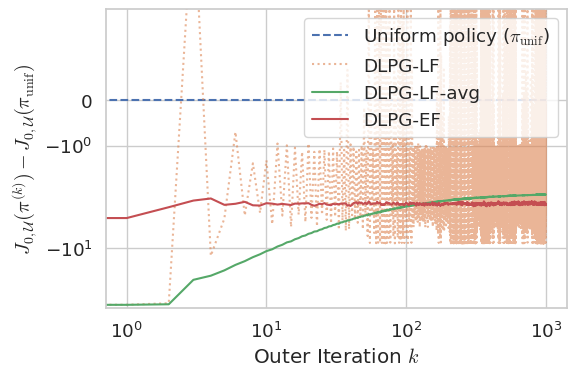

In [15]:
fig = plt.figure(figsize=(6, 4))
sns.set_theme(font_scale=1.2)

with sns.axes_style("whitegrid"):
    for name, J_v in algos.items():
        J_list, v_list = J_v
        dfs = []
        for J in J_list:
            dfs.append(pd.DataFrame({performance_label: J, iteration_label: np.arange(len(J))}))
        df = pd.concat(dfs)
        sns.lineplot(df, x=iteration_label, y=performance_label,  errorbar=None, label=name, linestyle=next(linestyle), marker=next(marker), markevery=10, markersize=3, markeredgecolor="tab:red", alpha=next(alphas))

    plt.ylim(None, 2)
    plt.xscale("log")
    plt.yscale("symlog")
    sns.move_legend(plt.gca(), "upper right")
    fig.tight_layout()

    plt.savefig(f"double-loop-exp-sd-J.pdf", bbox_inches="tight")
    plt.savefig(f"double-loop-exp-sd-J.png", bbox_inches="tight")

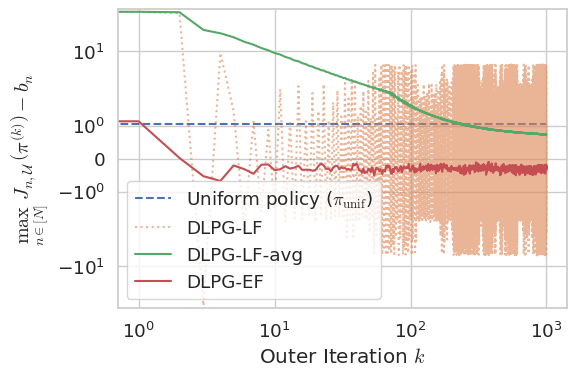

In [16]:
fig = plt.figure(figsize=(6, 4))
sns.set_theme(font_scale=1.2)
axes = []

with sns.axes_style("whitegrid"):
    for name, J_v in algos.items():
        J_list, v_list = J_v
        dfs = []
        for v in v_list:
            dfs.append(pd.DataFrame({violation_label: v, iteration_label: np.arange(len(v))}))
        df = pd.concat(dfs)
        sns.lineplot(df, x=iteration_label, y=violation_label,  errorbar=None, label=name, linestyle=next(linestyle), marker=next(marker), markevery=10, markersize=3, markeredgecolor="tab:red", alpha=next(alphas))
    # sns.move_legend(plt.gca(), "upper right")
    # plt.ylim(-10, 10)
    plt.xscale("log")
    plt.yscale("symlog")
    fig.tight_layout()

    plt.savefig(f"double-loop-exp-sd-vio.pdf", bbox_inches="tight")
    plt.savefig(f"double-loop-exp-sd-vio.png", bbox_inches="tight")